# Lab - CarPark Vacancy
Reference: Dataset was extracted from one of the KlangValley shopping mall (updated to Nov 2018)

Exercise: 
1. Predict the carpark vacant status in Zone A.




In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import shutil


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.feature_column import feature_column_v2 as fc

## Reading dataset

In [2]:
df_all = pd.read_csv("https://github.com/thenghui/trainerdata/raw/master/VacantBays.csv")
print('All dataset: {}'.format(df_all.shape))

df = df_all
print('Sep - Feb dataset: {}'.format(df.shape))



All dataset: (15501, 9)
Sep - Feb dataset: (15501, 9)


## Cleanup & prepare data

In [3]:
#Cleanup numbers

cleanup_nums = {"A": {"FULL": 0},
                "B": {"FULL": 0},
                "C": {"FULL": 0},
                "G": {"FULL": 0},
                "H": {"FULL": 0},
                "P": {"FULL": 0},
                "U": {"FULL": 0},
               }

df.replace(cleanup_nums, inplace=True)
df.dropna(subset=['A','B','C','G','H','P','U'])
print(df.shape)

(15501, 9)


In [4]:
# Convert to datetime

df['A'] = df['A'].astype(np.float64)
df['B'] = df['B'].astype(np.float64)
df['C'] = df['C'].astype(np.float64)
df['G'] = df['G'].astype(np.float64)
df['H'] = df['H'].astype(np.float64)
df['P'] = df['P'].astype(np.float64)
df['U'] = df['U'].astype(np.float64)
df['DateTime'] =  pd.to_datetime(df['DateTime'])
df.dtypes

DateTime      datetime64[ns]
IsoWeekday             int64
A                    float64
B                    float64
C                    float64
G                    float64
H                    float64
P                    float64
U                    float64
dtype: object

In [5]:
# Extract Hour and Minute
df['Hour'] = df.DateTime.apply(lambda x: x.hour)
df['Minute'] = df.DateTime.apply(lambda x: x.minute)
df.head()

,DateTime,IsoWeekday,A,B,C,G,H,P,U,Hour,Minute
0,2018-09-20 01:32:30.850890,4,770.0,2592.0,875.0,1410.0,1455.0,310.0,811.0,1,32
1,2018-09-20 01:39:01.932373,4,773.0,2590.0,876.0,1415.0,1459.0,310.0,810.0,1,39
2,2018-09-20 01:39:40.024931,4,773.0,2591.0,876.0,1414.0,1459.0,310.0,810.0,1,39
3,2018-09-20 01:39:52.258908,4,773.0,2591.0,876.0,1415.0,1459.0,310.0,810.0,1,39
4,2018-09-20 01:40:49.225890,4,773.0,2590.0,876.0,1412.0,1458.0,310.0,810.0,1,40


## Classify the carpark vacant status 


In [6]:
df.describe()

,IsoWeekday,A,B,C,G,H,P,U,Hour,Minute
count,15501.000000,15415.000000,15414.000000,15415.000000,15408.000000,15409.000000,15408.000000,15413.000000,15501.000000,15501.000000
mean,3.998581,704.462991,1434.660633,730.117418,793.190680,797.931209,209.521223,496.244339,11.490549,22.506806
std,1.993440,607.467157,1073.310776,672.026296,566.210323,582.460440,106.322034,287.991933,6.929934,16.765946
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,76.000000,281.000000,59.000000,212.000000,197.000000,119.000000,234.000000,5.000000,15.000000
50%,4.000000,738.000000,1585.000000,731.000000,861.000000,857.000000,257.000000,552.000000,11.000000,30.000000
75%,6.000000,1053.000000,2564.000000,1083.000000,1389.000000,1413.000000,304.000000,785.000000,18.000000,39.000000
max,7.000000,1792.000000,2646.000000,1956.000000,1503.000000,1525.000000,317.000000,831.000000,23.000000,46.000000


In [7]:
# Define status for Carpark Zone A
def A_state(x):
    if x > 1053:
        return 4 # you are early!
    elif x > 738:
        return 3 # plenty of vacancy
    elif x > 76:
        return 2 # limited bay
    elif x > 0:
        return 1 # good luck
    else:
        return 0
    
df['A_State'] = df['A'].apply(A_state)
df.head()

,DateTime,IsoWeekday,A,B,C,G,H,P,U,Hour,Minute,A_State
0,2018-09-20 01:32:30.850890,4,770.0,2592.0,875.0,1410.0,1455.0,310.0,811.0,1,32,3
1,2018-09-20 01:39:01.932373,4,773.0,2590.0,876.0,1415.0,1459.0,310.0,810.0,1,39,3
2,2018-09-20 01:39:40.024931,4,773.0,2591.0,876.0,1414.0,1459.0,310.0,810.0,1,39,3
3,2018-09-20 01:39:52.258908,4,773.0,2591.0,876.0,1415.0,1459.0,310.0,810.0,1,39,3
4,2018-09-20 01:40:49.225890,4,773.0,2590.0,876.0,1412.0,1458.0,310.0,810.0,1,40,3


## Split into dataset of: Train, Validation, Test (70%-20%-10%)

In [8]:
df_train0, df_valid0, df_test0 = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])

# select only Featured columns
df_train = df_train0[['A_State','Hour','Minute','IsoWeekday']]
df_valid = df_valid0[['A_State','Hour','Minute','IsoWeekday']]
df_test = df_test0[['A_State','Hour','Minute','IsoWeekday']]

print('Train set: {}'.format(df_train.shape))
print('Validate set: {}'.format(df_valid.shape))
print('Test set: {}'.format(df_test.shape))



Train set: (10850, 4)
Validate set: (3100, 4)
Test set: (1551, 4)


## Feature & Label 

In [9]:
FEATURES_NUM = ['Hour','Minute','IsoWeekday']
LABEL = 'A_State'
NUM_CLASSES = 5

In [10]:
model = tf.keras.Sequential()
# Input - Layer
model.add(layers.Dense(32, activation = tf.keras.activations.relu, input_shape=(3,))) # 3 is cause of 3 features
# Hidden - Layers
#model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
#model.add(layers.Dense(64, activation = "relu"))
#model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(64, activation = tf.keras.activations.relu))
#model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
# Output- Layer
model.add(layers.Dense(5, activation = tf.keras.activations.softmax)) # 5 categories

model.summary()
          
model.compile(
    #optimizer = tf.keras.optimizers.RMSprop(lr=0.01),
    #loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    loss = tf.keras.losses.categorical_crossentropy,   
    metrics = ["accuracy"]
)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 2,565
Trainable params: 2,565
Non-trainable params: 0
_________________________________________________________________


In [11]:
#print(df_train.drop([LABEL], axis=1).values)
#print(df_train[LABEL].values.reshape((10850,-1)))

history = model.fit(
 df_train.drop([LABEL], axis=1), 
 tf.keras.utils.to_categorical(df_train[LABEL], NUM_CLASSES),
 epochs= 50,
 batch_size = 32,
 validation_data = (df_valid.drop([LABEL], axis=1), 
                    tf.keras.utils.to_categorical(df_valid[LABEL]))
)

Train on 10850 samples, validate on 3100 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
10850/10850 [==============================] - 1s 65us/sample - loss: 1.3744 - acc: 0.4025 - val_loss: 1.2326 - val_acc: 0.4703
Epoch 2/50
10850/10850 [==============================] - 1s 50us/sample - loss: 1.2234 - acc: 0.4867 - val_loss: 1.1710 - val_acc: 0.4900
Epoch 3/50
10850/10850 [==============================] - 1s 51us/sample - loss: 1.1719 - acc: 0.5139 - val_loss: 1.1327 - val_acc: 0.5394
Epoch 4/50
10850/10850 [==============================] - 1s 51us/sample - loss: 1.1261 - acc: 0.5359 - val_loss: 1.0921 - val_acc: 0.5410
Epoch 5/50
10850/10850 [==============================] - 1s 51us/sample - loss: 1.0909 - acc: 0.5536 - val_loss: 1.0486 - val_acc: 0.5642
Epoch 6/50
10850/10850 [==============================] - 1s 52us/sample - loss: 1.0412 - acc: 0.5747 - val_loss: 1.0111 - val_acc: 0.5719
Epoch 7/50
10850/10850 [==============================] - 1s 52us/sam

In [12]:
print("Test-Accuracy:", np.mean(history.history["val_acc"]))


Test-Accuracy: 0.7079549


In [13]:
score = model.evaluate(df_test.drop([LABEL], axis=1).values, 
                       tf.keras.utils.to_categorical(df_test[LABEL], NUM_CLASSES), 
                       batch_size=32)
score

1551/1551 [==============================] - 0s 18us/sample - loss: 0.6286 - acc: 0.7582


[0.6285700234269266, 0.7582205]

In [14]:
result = model.predict(df_test.drop([LABEL], axis=1), 
                       batch_size=32)
result

array([[5.6339769e-07, 2.3948395e-11, 1.1916999e-04, 3.9948768e-06,
        9.9987626e-01],
       [1.2335182e-09, 1.0997458e-08, 1.6531728e-02, 9.2583883e-01,
        5.7629451e-02],
       [3.9928174e-04, 1.5911410e-02, 7.1360773e-01, 1.5087084e-01,
        1.1921076e-01],
       ...,
       [9.3996932e-06, 9.4848342e-04, 2.1084914e-01, 1.0910040e-01,
        6.7909259e-01],
       [5.2733242e-04, 2.3950743e-03, 4.9633750e-01, 3.8082686e-01,
        1.1991317e-01],
       [2.8586192e-06, 6.1013938e-10, 3.9562047e-04, 1.2412405e-03,
        9.9836022e-01]], dtype=float32)

In [17]:
df_test.tail() #head / tail

,A_State,Hour,Minute,IsoWeekday
14855,3,6,15,5
4541,4,10,15,2
12429,4,22,45,7
10601,3,20,30,2
6333,4,3,30,7


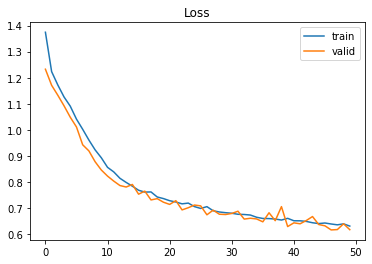

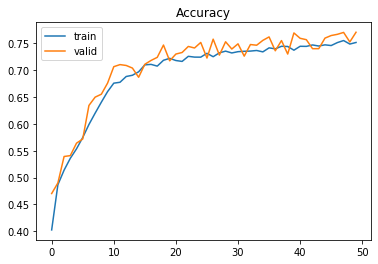

In [18]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(111)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.legend()
pyplot.show()

# plot accuracy during training
pyplot.subplot(111)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='valid')
pyplot.legend()
pyplot.show()

## Determine metrics for validation - Accuracy

In [ ]:
def print_accuracy(model, df):
  metrics = model.evaluate(input_fn = tf.estimator.inputs.pandas_input_fn(
    x = df,
    y = df[LABEL],
    batch_size = 128,
    shuffle = False
  ))
  print('Accuracy on dataset = {}'.format(metrics['accuracy']))
    
#print_accuracy(model, df_valid)

## Model: DNN Classifier

In [ ]:
# DNNClassifier
OUTDIR = 'carparkClass_trained'
tf.logging.set_verbosity(tf.logging.INFO)
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

model = tf.estimator.DNNClassifier(
    hidden_units = [512, 256, 128], 
    feature_columns = [tf.feature_column.numeric_column('Hour'),
                       tf.feature_column.numeric_column('Minute'),
                       tf.feature_column.numeric_column('IsoWeekday')
                      ], 
    activation_fn = tf.nn.relu,
    n_classes=5,
    optimizer=tf.train.AdamOptimizer(
      learning_rate=0.01,
      #l1_regularization_strength=0.001
    ),
    #loss_reduction='weighted_sum',
    model_dir = OUTDIR,
#    config=tf.estimator.RunConfig(save_summary_steps=2,
#                                  save_checkpoints_steps=2)
)

model.train(input_fn = tf.estimator.inputs.pandas_input_fn(
    x = df_train,
    y = df_train[LABEL],
    batch_size = 128,
    num_epochs = 50,
    shuffle = True
  ));

print_accuracy(model, df_valid)

## Prediction 

In [ ]:
predictions = model.predict(input_fn = tf.estimator.inputs.pandas_input_fn(
#    x = pd.DataFrame({
#                      'Hour':[9,10,12],
#                      'Minute':[0,0,0],
#                      'IsoWeekday':[4,4,5]}),
    x = df_test,
    y = None,
    batch_size = 64,
    shuffle = False
  ))

for items in predictions:
  print(items)

In [ ]:
df_test.head()